<a href="https://colab.research.google.com/github/andriussvilys/VAE_mnist/blob/master/VAE_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# normalize image values from range [0:255] to [0:1]
x_train = x_train / 255
x_test = x_test / 255

In [4]:
img_width = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

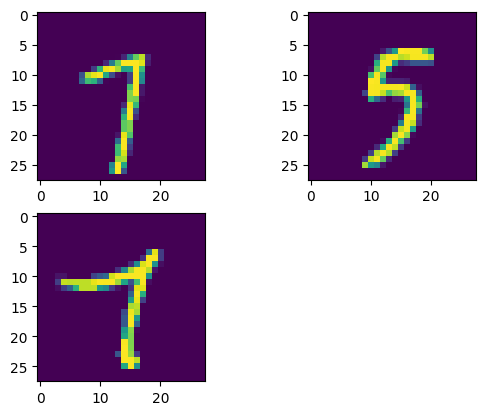

In [5]:
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[42][:,:,0])

plt.subplot(222)
plt.imshow(x_train[420][:,:,0])

plt.subplot(223)
plt.imshow(x_train[4200][:,:,0])

In [6]:
latent_dim = 2

ENCODER:

In [7]:
input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

In [8]:
conv_shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

In [9]:
z_mu = Dense(latent_dim, name='latent_mu')(x)
z_sigma = Dense(latent_dim, name='latent_sigma')(x)

Reparametrization trick:

In [10]:
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

sample vector from latent distribution

z is the lambda custom layer we are ladding for gradient descent calculations

In [11]:
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z' )([z_mu, z_sigma])

In [12]:
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 64)           36928     ['conv2d_1[0][0]']            
                                                                                            

DECODER

In [13]:
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1],conv_shape[2],conv_shape[3]))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2,2))(x)
x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

In [14]:
decoder = Model(decoder_input, x, name='decoder')
print(decoder.summary())

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 12544)             37632     
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 28, 28, 32)        18464     
 anspose)                                                        
                                                                 
 decoder_output (Conv2DTran  (None, 28, 28, 1)         289       
 spose)                                                          
                                                                 
Total params: 56385 (220.25 KB)
Trainable params: 56385 (22

In [15]:
z_decoded = decoder(z)

In [16]:
# class CustomLayer(keras.layers.Layer):
#   def vae_loss(self, x, z_decoded):
#     x = K.flatten(x)
#     z_decoded = K.flatten(z_decoded)

#     # reconstruction loss
#     recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)

#     # KL divergence
#     kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=1)

#     return K.mean(recon_loss + kl_loss)

#   def call(self, inputs):
#     x = inputs[0]
#     z_decoded = inputs[1]
#     print(x, z_decoded)
#     loss = self.vae_loss(x, z_decoded)
#     self.add_loss(loss, inputs=inputs)
#     return x

In [17]:
# y = CustomLayer()([input_img, z_decoded])

# vae = Model(input_img, y, name='vae')

# vae.compile(optimizer='adam', loss=None)
# vae.summary()

# vae.fit(x_train, None, epochs=10, batch_size=32, validation_split=0.2)

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

class CustomLayer(Layer):
    def vae_loss(self, x, z_decoded, z_mu, z_sigma):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        # Reconstruction loss
        recon_loss = tf.keras.metrics.binary_crossentropy(x, z_decoded)

        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=1)

        return K.mean(recon_loss + kl_loss)

    def call(self, inputs):
        x, z_decoded, z_mu, z_sigma = inputs
        loss = self.vae_loss(x, z_decoded, z_mu, z_sigma)
        self.add_loss(loss, inputs=inputs)
        return x

# Assuming you have already defined input_img, z_decoded, z_mu, z_sigma, x_train, and other necessary variables

# Create an instance of the CustomLayer
custom_layer = CustomLayer()

# Define the VAE model
y = custom_layer([input_img, z_decoded, z_mu, z_sigma])
vae = Model(input_img, y, name='vae')

# Compile the model
vae.compile(optimizer='adam', loss=None)

# Print model summary
vae.summary()

# Train the model
vae.fit(x_train, None, epochs=10, batch_size=32, validation_split=0.2)


Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 64)           36928     ['conv2d_1[0][0]']            
                                                                                                

313/313 [==============================] - 1s 3ms/step


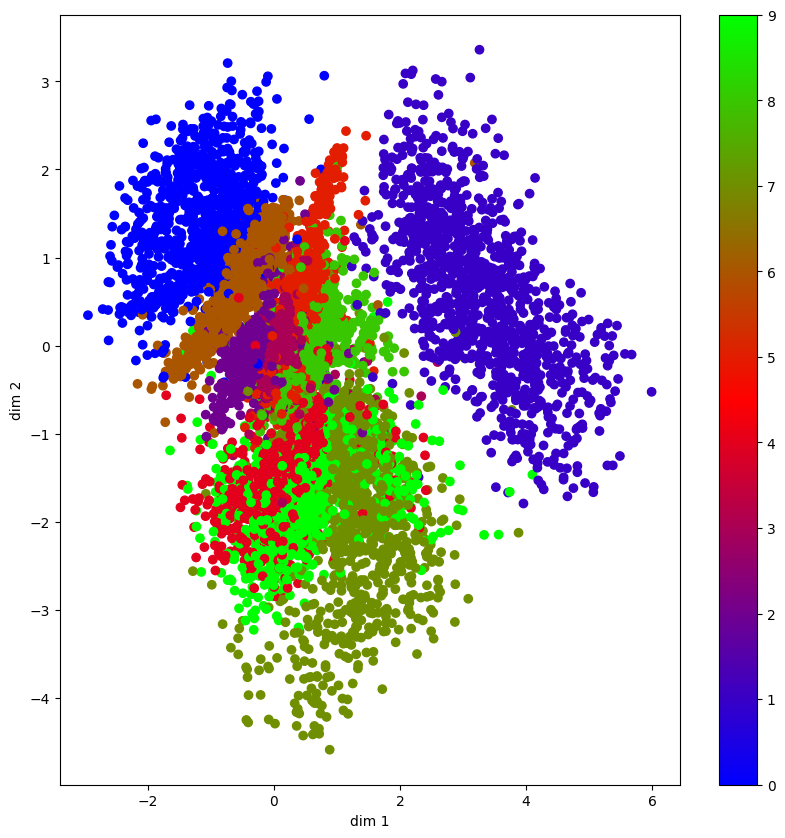

In [19]:
mu, _, _ = encoder.predict(x_test)
plt.figure(figsize=(10,10))
plt.scatter(mu[:,0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

1/1 [==============================] - 0s 28ms/step


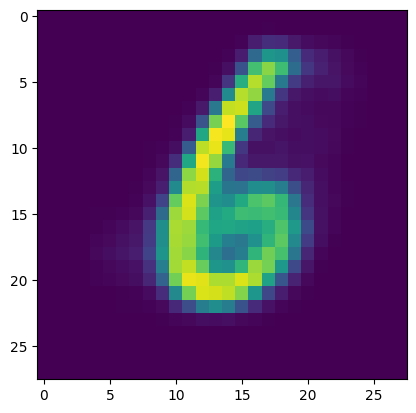

In [21]:
sample_vector = np.array([[0,1]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)